In [4]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "0"

# Hard EM - VAE: Fashion MNIST

In this notebook, we test the effectiveness and speed of hard-EM applied to a factor analysis and homoskedastic encoder.

We test this notebook considering an adam optimiser for both the VAE and the E and M steps of DLM hard EM.

# Fitting a distribution $q_n$ given $\boldsymbol\theta$

In this section, we find a variational distribution $q_n$ for $\boldsymbol\theta_\text{vae}$ and $\boldsymbol\theta_\text{hard-em}$. We consider a dataset ${\bf X}_\text{test}$ and train an unamortised variational distribution of the form

$$
    q_n(z_n) = \mathcal{N}(z_n \vert \mu_n, \sigma_n)
$$

In [1]:
import pickle
import matplotlib.pyplot as plt

In [2]:
import jax
import hlax
import optax
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
with open("../results.pkl", "rb") as f:
    output = pickle.load(f)

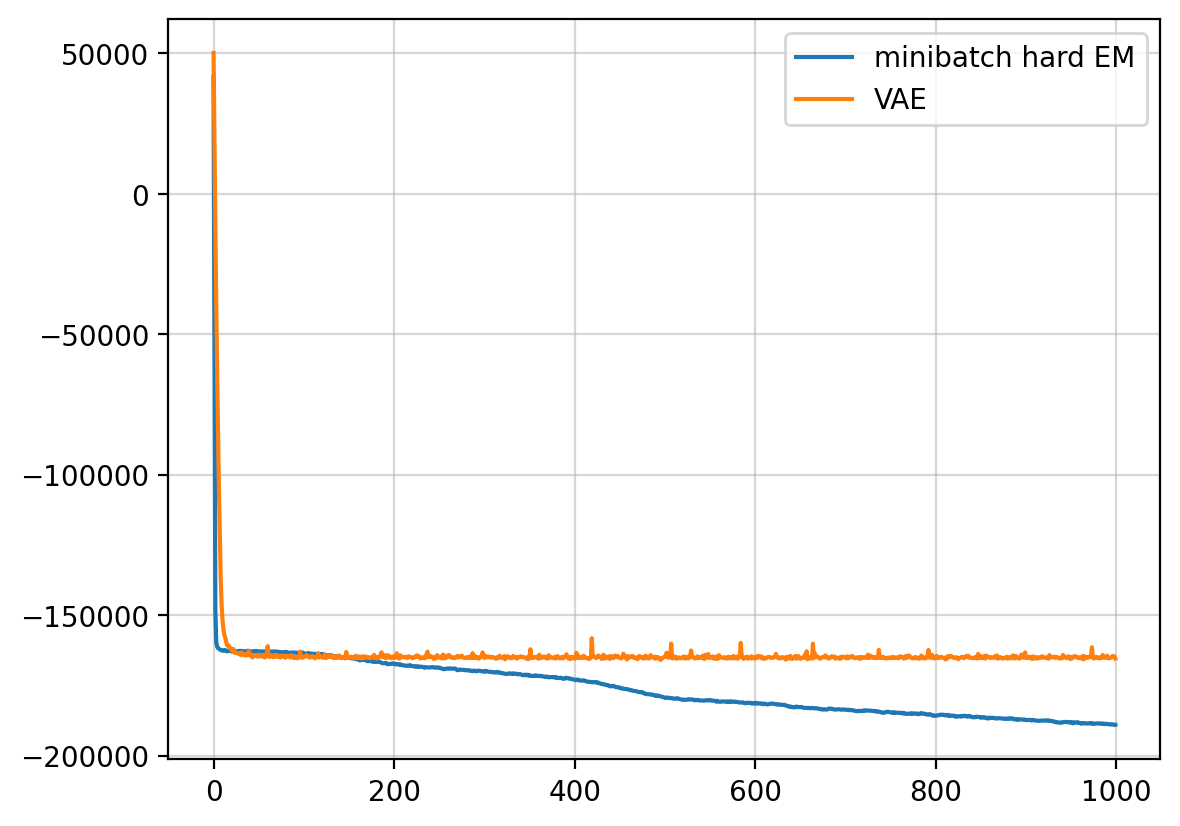

In [5]:
plt.plot(output["hardem"]["hist_loss"], label="minibatch hard EM")
plt.plot(output["vae"]["hist_loss"], label="VAE")
plt.legend()
plt.grid(alpha=0.5)

In [6]:
n_train = 10_000
n_test = 1_000
train, test = hlax.datasets.load_fashion_mnist(n_train, n_test)
X_train, X_test = train[0], test[0]
num_train, dim_obs = X_train.shape

In [7]:
num_is_samples = 20
num_test_epochs = 5_000
tx_test = optax.adam(1e-4)
dim_latent = 50
_, dim_obs = X_test.shape
q_encoder = hlax.models.GaussEncoder(dim_latent)

In [8]:
key = jax.random.PRNGKey(314)
key_train, key_eval= jax.random.split(key)
keys_eval = jax.random.split(key_eval, len(X_test))

vmap_neg_iwmll = jax.vmap(hlax.training.neg_iwmll, (0, 0, None, 0, None, None, None))

In [9]:
decoder = hlax.models.DiagDecoder(dim_obs, dim_latent)

In [10]:
dict_mll_epochs = {}

checkpoint_vals = output["hardem"]["checkpoint_params"].keys()
for keyv in tqdm(checkpoint_vals):
    params_decoder_vae = output["vae"]["checkpoint_params"][keyv]
    params_decoder_hem = output["hardem"]["checkpoint_params"][keyv]


    vae_res = hlax.training.train_encoder(key_train, X_test, q_encoder, decoder,
                                          params_decoder_vae, tx_test, num_test_epochs,
                                          num_is_samples, leave=False)

    hem_res = hlax.training.train_encoder(key_train, X_test, q_encoder, decoder,
                                          params_decoder_hem, tx_test, num_test_epochs,
                                          num_is_samples, leave=False)
    
    mll_vae = -vmap_neg_iwmll(keys_eval, vae_res["params"], params_decoder_vae, X_test, q_encoder, decoder, 50)
    mll_hem = -vmap_neg_iwmll(keys_eval, hem_res["params"], params_decoder_hem, X_test, q_encoder, decoder, 50)
    
    mll_vals = np.c_[mll_hem, mll_vae]
    dict_mll_epochs[keyv] = mll_vals

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

# Comparing IWMLL

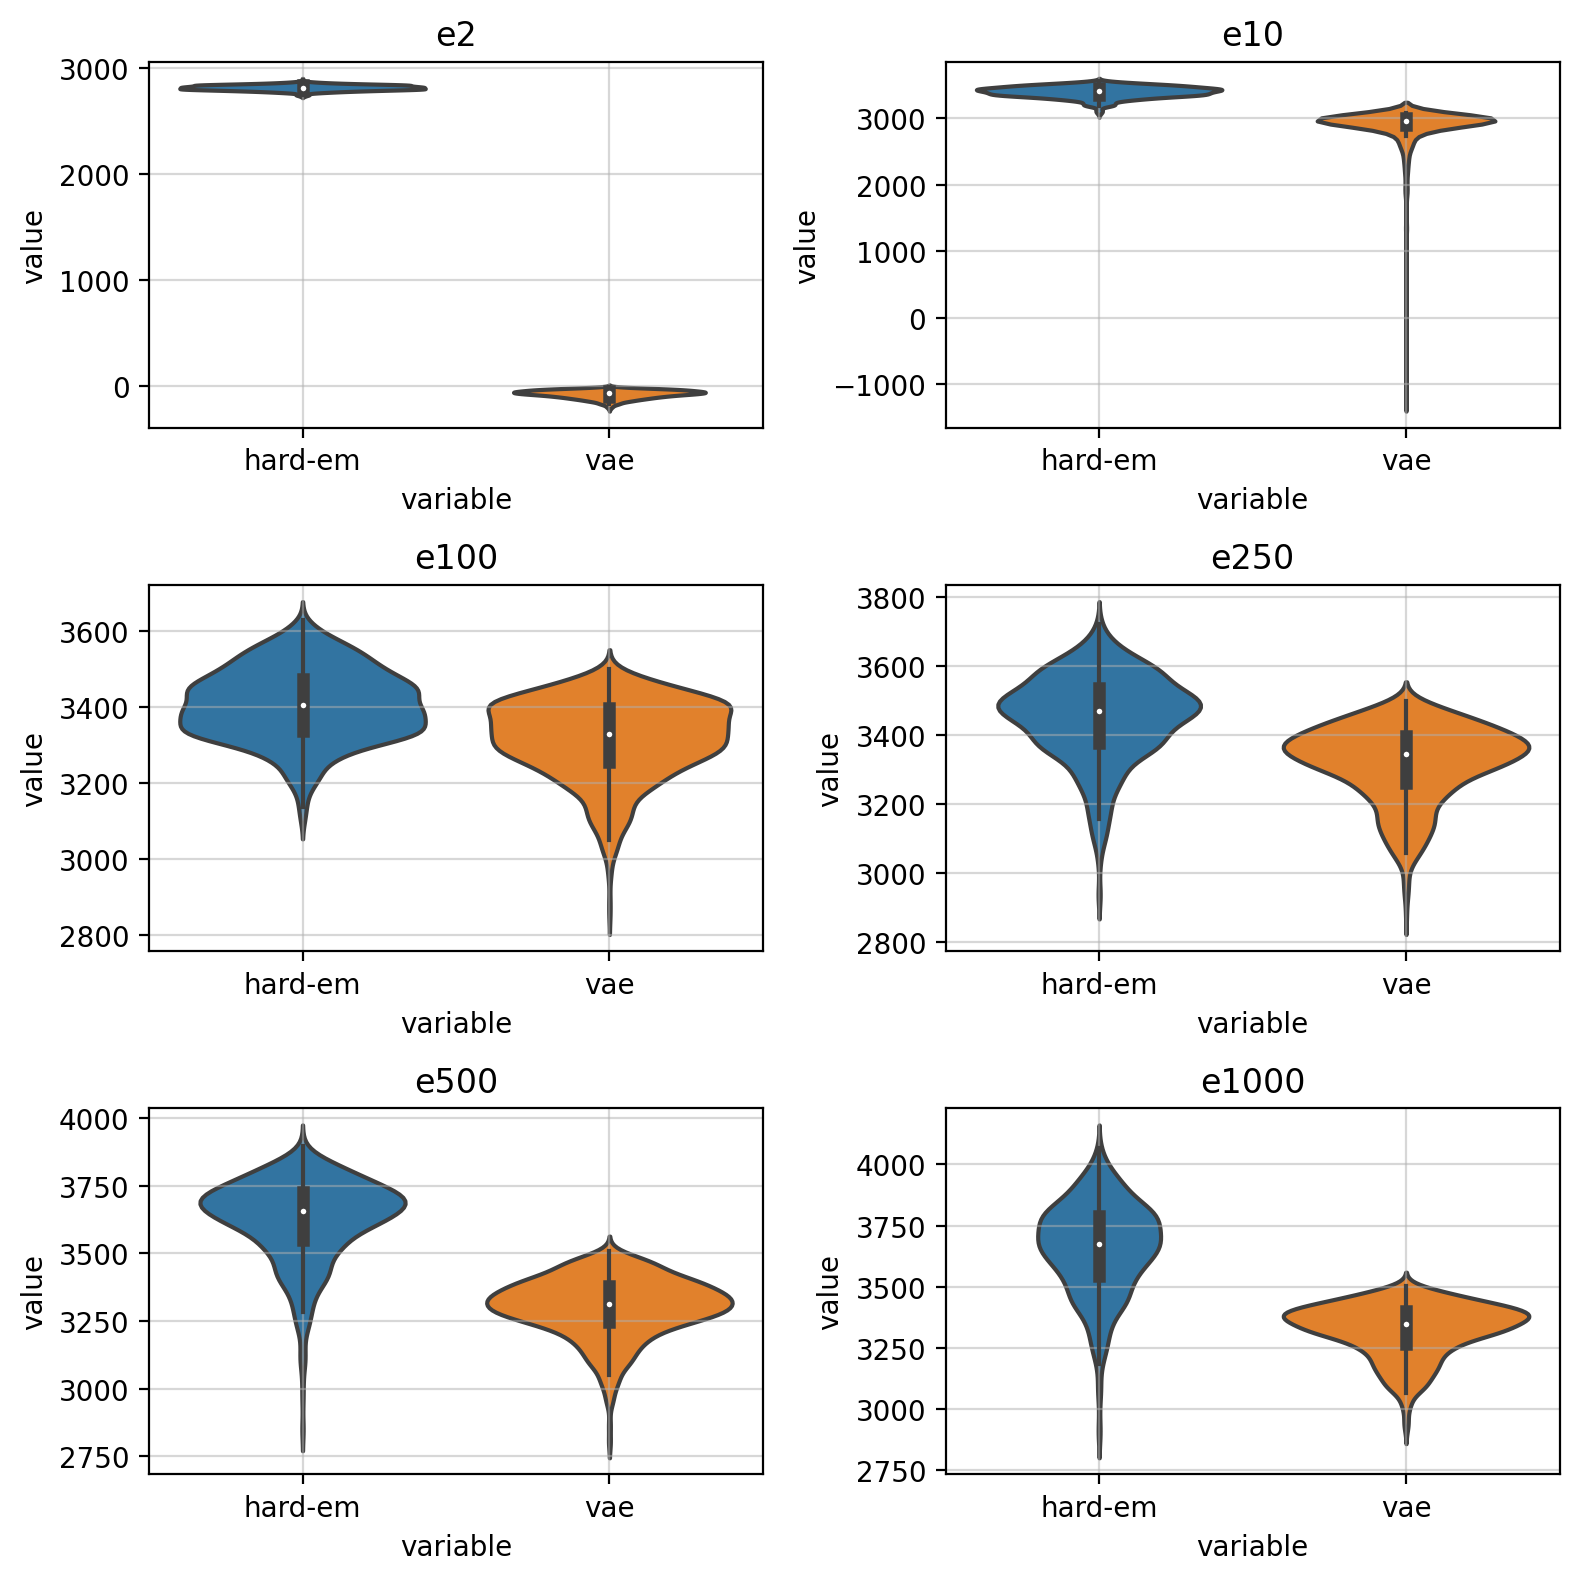

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(8, 8))

for ax, key in zip(axs.ravel(), dict_mll_epochs):
    df_mll = pd.DataFrame.from_dict(dict_mll_epochs[key])
    df_mll.columns = ["hard-em", "vae"]
    sns.violinplot(df_mll.melt(), x="variable", y="value", ax=ax)
    ax.grid(alpha=0.5)
    ax.set_title(key)
    
# axs[-1, -1].axis("off")
plt.tight_layout()